In [1]:
import numpy as np
import pandas as pd
from shapely import centroid
import os
import shutil

In [22]:
#!pip install shapely
#!pip install mapclassify
#!pip install geopandas

#  {city}_death_simplices_by_death_in_dim_1.npy data

This is the basic data for the paper result: Triangles corresponding to the resource holes, given by lon/lat pairs for each vertex,
and then the death filtration value, zscore of that value, and the ratio of the dath to birth filtration value. The triangles are stored as Shapely Polygon objects. Below extracts the vertex coords, the centroid coords, and stores everything in a data frame

## Convert death simplex data to Pandas dataframes

In [2]:
def convert_simplicies_to_df(data):

    keys = ['lon1','lat1','lon2','lat2','lon3','lat3','lon_center','lat_center',
            'death_filtration_value','death_filtration_zscore','death_birth_ratio']
    
    pdict = dict(zip(keys,[[] for key in keys]))
    
    for d in data:
        coords = d[0].__geo_interface__['coordinates'][0]

        #get coordinates of centroid, probably useful
        lonc, latc = centroid(d[0]).__geo_interface__['coordinates']

        # make sure all the polygons are triangles and the last coordinate pair is redundant and we can throw it away
        assert coords[-1] == coords[0]
        assert len(coords) == 4
    
        lon1, lat1= coords[0]
        lon2, lat2 = coords[1]
        lon3, lat3 = coords[2]

        # get death filtration values, zscores, and death/birth ratio
        dfv, dfz, dbr = d[1:]

        row = [lon1, lat1, lon2, lat2, lon3, lat3, lonc, latc, dfv, dfz, dbr]
        for ii, key in enumerate(keys):
            pdict[key].append(row[ii])

    return pd.DataFrame(pdict)

        


        


In [ ]:
paths = ['../Salt Lake City/slc_death_simplices_by_death_in_dim_1.npy',
         '../Chicago/chc_death_simplices_by_death_in_dim_1.npy',
         '../Atlanta/atl_death_simplices_by_death_in_dim_1.npy',
         '../Jacksonville/jax_death_simplices_by_death_in_dim_1.npy',
         '../NYC/nyc_death_simplices_by_death_in_dim_1.npy'
        ]
for path in paths:
    folder_name = path.split('/')[2].split('_')[0]
    file_name = '{}.csv'.format(path.split('/')[2].split('.')[0])

    try: os.mkdir('../project_data/{}'.format(folder_name))
    except FileExistsError: print('{} Folder already exists. Continuing'. format(folder_name))
    shutil.copy(path, '../project_data/{}'.format(folder_name))
    data = np.load(path, allow_pickle=True)

    df = convert_simplicies_to_df(data)

    df.to_csv('../project_data/{}/{}'.format(folder_name,file_name))

# PRESIDENT_precinct_general.csv


This is the raw # of votes by precinct broken down by party AND voting method (absentee, non-absentee, etc.)
A few things to note:
- Does NOT include total registered voters by precinct
- However, that data can be found elsewhere. For instance, Chicago gives these numbers by precinct [here](https://chicagoelections.gov/elections/results) (however, not by voting method). 
- Does NOT include demographic data
- Does NOT include spatial data, so precincts need to be looked up elsewhere to get their location beyond just what county they're in
- The precinct conventions are different for different cities, counties, etc as illustrated below
- There is no national database of precinct boundaries. But they do seem to be getable city-by-city. For example, the [2012-2022 Chicago precinct boundaries](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Ward-Precincts-2012-2022-/uvpq-qeeq) are stored as sets of lat/lon pairs for vertices. I think packages like Shapely should allow us to easily check which ones intersect with triangles in the data above
- I've put the Chicago coordinates in the corresponding data folder [here](../project_data/chc/ChicagoPrecincts2012_2022.csv)
  

In [ ]:
data = pd.read_csv('../project_data/PRESIDENT_precinct_general.csv')

## Selecting, e.g. Chicago precincts

Chicago falls under the Cook County jurisdiction. There are multiple Cook counties, and the one in Illinois includes more than just Chicago

In [ ]:
cook_data = data[(data.jurisdiction_name == 'COOK') & (data.state == 'ILLINOIS')] # There are multiple Cook counties, and the one in Illinois includes more than just Chicago

In [ ]:
np.unique(cook_data.precinct)

Even in Cook County, precincts have different naming conventions.

Found [map of precincts here](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Ward-Precincts-2012-2022-/uvpq-qeeq).

All Chicago precincts are identified by a Ward # and a Precinct # that's not unique across Wards.
Selecting for things that look like that gives 2069 precincts, which is consistent with googling it for the map
covering 2012-2022. **Note:** The [precinct map for Chicago was redrawn](https://app.chicagoelections.com/Documents/general/Chicago%20Board%20of%20Elections%20Releases%20New%20Ward%20and%20Precinct%20Maps.pdf) ahead of the 2022 General Election, reducing the
number of precincts. This is something we're going to have to be careful with.



In [ ]:
chicago_precincts = []
for ii, precinct in enumerate(np.unique(x.precinct)):
    if 'WARD' in precinct:
        chicago_precincts.append(precinct)

chicago_data = cook_data[cook_data.precinct.isin(chicago_precincts)]
print(len(np.unique(chicago_data.precinct)))

# Chicago Precinct Maps

Found map of Chicago Precincts for 2012-2022 [here](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Ward-Precincts-2012-2022-/uvpq-qeeq). Data saved as csv [here](../project_data/chc/ChicagoPrecincts2012_2022.csv)

In [3]:
from shapely import MultiPolygon, Polygon, wkt, intersection
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

### Get data into geopandas format, shapely objects instead of strings

In [4]:
precs = pd.read_csv('../project_data/chc/ChicagoPrecincts2012_2022.csv')

In [5]:
precs['the_geom'] = precs['the_geom'].apply(wkt.loads)
precs = precs.rename(columns={'the_geom':'geometry'})

In [6]:
precs = gpd.GeoDataFrame(precs, crs='epsg:4326')


geopandas has nice plotting function that looks for a "geometry" column

<Axes: >

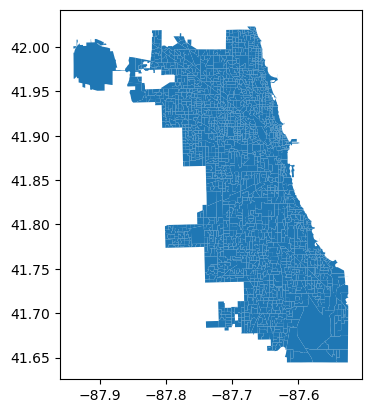

In [7]:

precs.plot()


### Map together with death simplices

In [8]:
dsimp_data = np.load('../project_data/chc/chc_death_simplices_by_death_in_dim_1.npy', allow_pickle=True)
dsimp_dict = dict(zip(['geometry','death_filtration_value','death_filtration_zscore','death_birth_ratio'],dsimp_data.T))
dsimps = pd.DataFrame(dsimp_dict)
dsimps = gpd.GeoDataFrame(dsimps, crs='epsg:4326')

<Axes: >

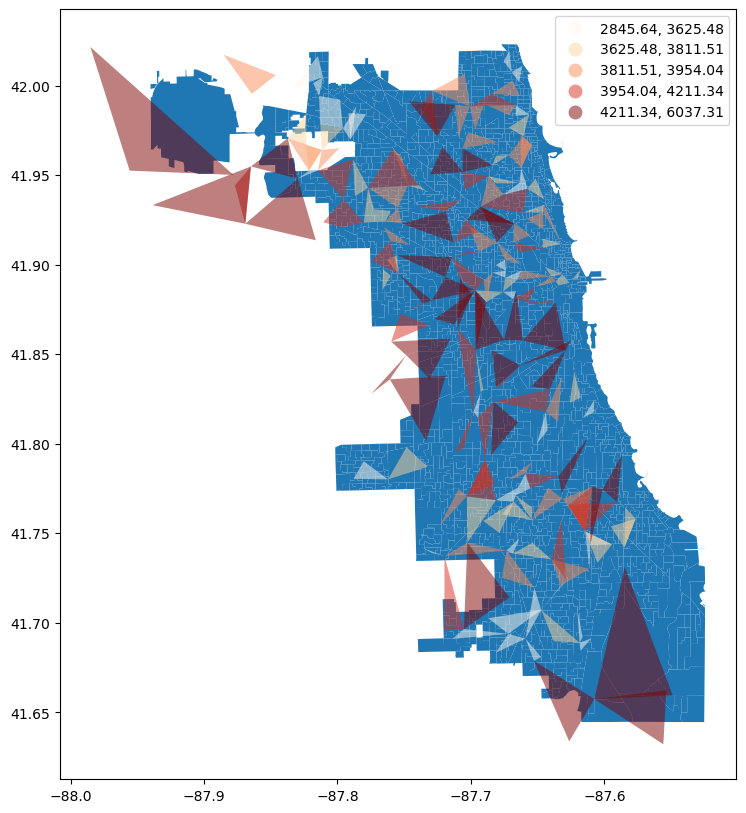

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
precs.plot(ax=ax)
dsimps.plot(alpha=.5,ax=ax,column='death_filtration_value',
                                         cmap='OrRd',legend=True,scheme='quantiles')

Something to keep in mind is that the paper makes a cut at death_birth_ratio=1.05 to filter out artifacts

In [10]:
dsimps = dsimps[dsimps.death_birth_ratio>=1.05]

<Axes: >

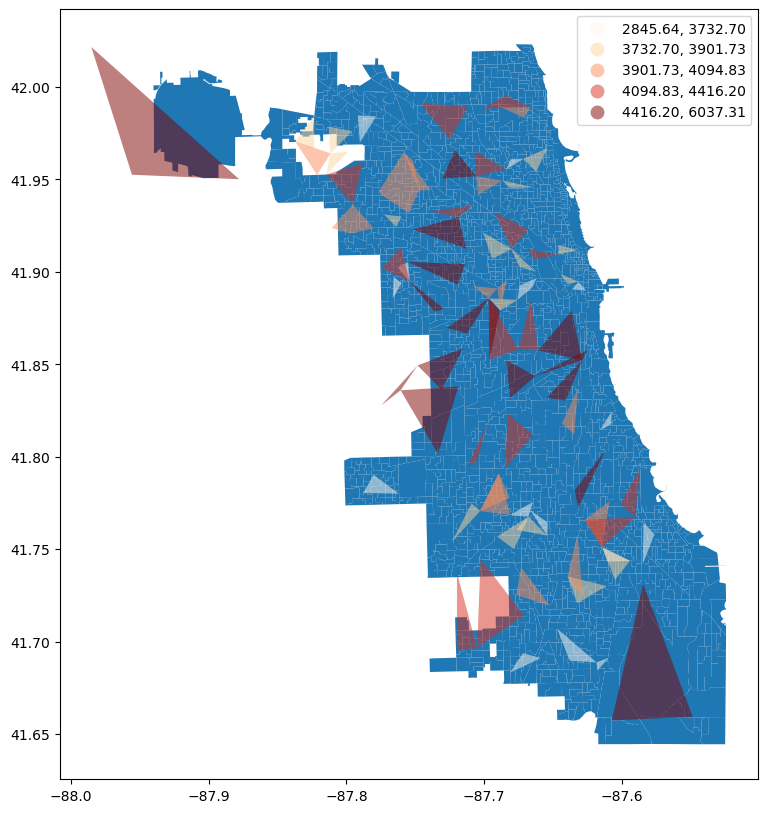

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
precs.plot(ax=ax)
dsimps.plot(alpha=.5,ax=ax,column='death_filtration_value',
                                         cmap='OrRd',legend=True,scheme='quantiles')

### Check which precincts overlap with which death simplices

In [12]:

n_intersect = []
mean_dfv = []
area_intersect = []
for ii, prec in precs.iterrows():
    dfvs_ii = []
    dsimps_ii = []
    areas_ii = []
    
    for jj, dsimp in dsimps.iterrows():

        if not intersection(prec.geometry,dsimp.geometry).area == 0:
            
            dsimps_ii.append(jj)
            dfvs_ii.append(dsimp.death_filtration_value)
            
    if len(dfvs_ii) == 0:
        mean_dfv.append(0)
    else:
        mean_dfv.append(np.mean(dfvs_ii))
                        
    n_intersect.append(len(dsimps_ii))


precs['n_intersect'] = n_intersect
precs['mean_dfv'] = mean_dfv


#### Precincts by # of intersections with death simplex

Text(0.5, 1.0, 'Chicago Voting Precincts and Simplex Overlap')

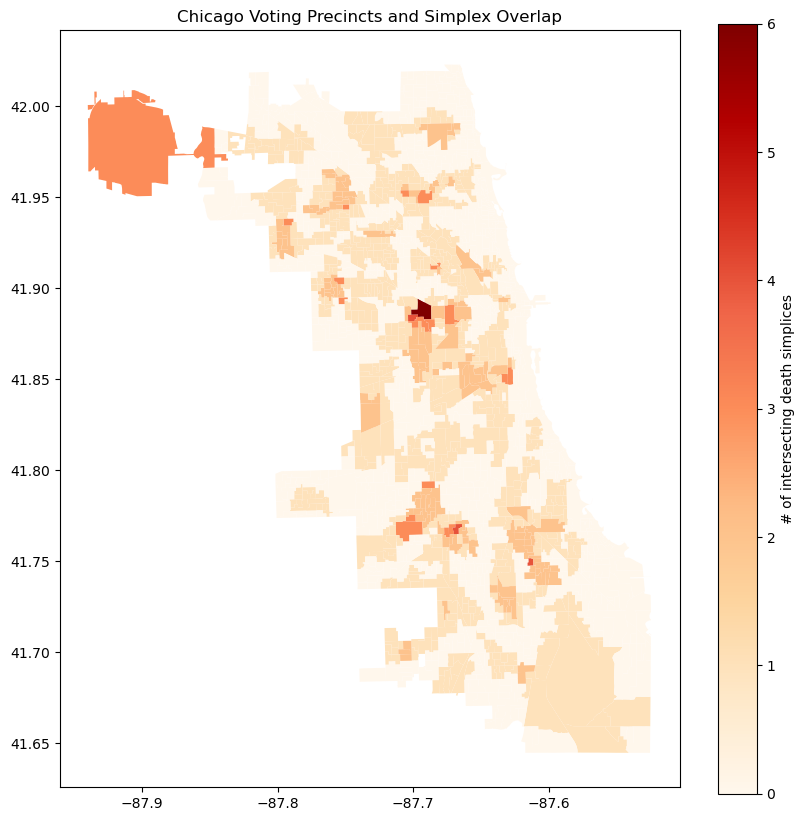

In [24]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
precs.plot(ax=ax,column='n_intersect',cmap='OrRd',legend=True,legend_kwds={"label": "# of intersecting death simplices"})
ax.set_title('Chicago Voting Precincts and Simplex Overlap')

#### Precincts by average intersecting death filtration value

<Axes: >

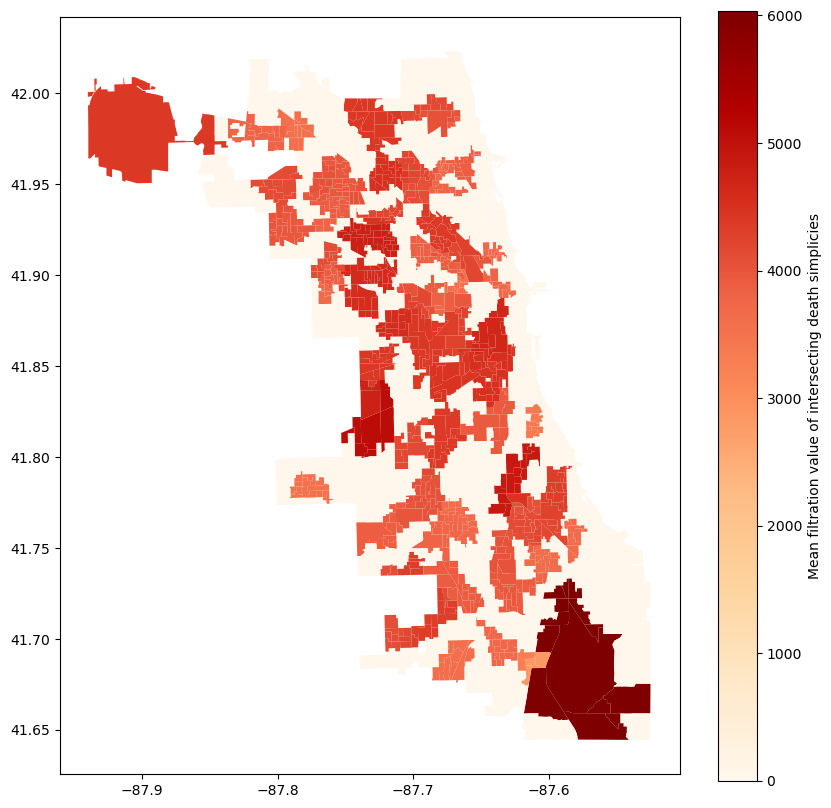

In [21]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
precs.plot(ax=ax,column='mean_dfv',cmap='OrRd',legend=True,legend_kwds={"label": "Mean filtration value of intersecting death simplicies"})

In [ ]:
!pip install mapclassify